<a href="https://colab.research.google.com/github/abollo/colab/blob/master/AE_CGAN_mnist_encoder_dim_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28)
y_train.shape:(60000,)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0 [D loss: 0.895651] [G loss: 0.620750] [AE loss: 0.000030] 


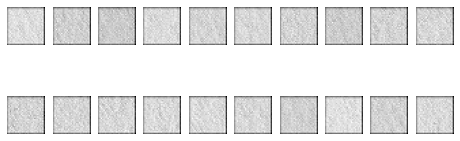

Epoch: 2000 [D loss: 0.567140] [G loss: 1.231332] [AE loss: 0.000000] 


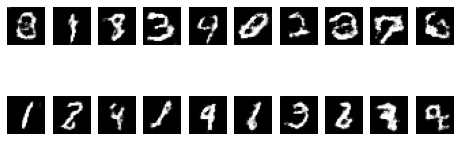

In [0]:
# -*- coding: utf-8 -*-
'''
condition gan add Autoencoder
'''

'''
mount the google drive 

from google.colab import drive
drive.mount('/content/drive')
'''
import tensorflow as tf
from numpy.random import randn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import cv2
import numpy as np
from numpy.linalg import lstsq
from scipy.linalg import orth
from scipy.stats import ortho_group
import pandas as pd


# classes dictionary
label_dict = {0: 'tshirt',
			 1: 'trouser',
			 2: 'pullover',
			 3: 'dress',
			 4: 'coat',
			 5: 'sandal',
			 6: 'shirt',
			 7: 'sneaker',
			 8: 'bag',
			 9: 'boot'}
 
def load_minst_data():
	# load the data
	(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
	# normalize our inputs to be in the range[-1, 1]
	x_train = (x_train.astype(np.float32) - 127.5)/127.5
	# convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
	# 784 columns per row
	return (x_train, y_train, x_test, y_test)
 
x_train, y_train, x_test, y_test = load_minst_data()
input_classes =pd.Series(y_train).nunique()
print("x_train shape: {}".format(x_train.shape))
print("y_train.shape:{}".format(y_train.shape))

class ACGAN():
	def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100,encoder_dim=1):
		# Input shape
		self.img_rows = input_rows
		self.img_cols = input_cols
		self.channels = input_channels
		self.img_shape = (self.img_rows, self.img_cols, self.channels)
		self.num_classes = input_classes
		self.latent_dim = latent_dim
		self.encoder_dim = encoder_dim

		optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
		losses2 = ['binary_crossentropy', 'mean_absolute_error']
		losses3 = [ 'mean_absolute_error']
		losses4 = ['binary_crossentropy']
		losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']
		losses_encoder = ['sparse_categorical_crossentropy','mean_absolute_error']


		# Build and compile the discriminator
		self.discriminator = self.build_discriminator2()
		self.discriminator.compile(loss=losses4,optimizer=optimizer,metrics=['accuracy'])

		# Build the generator
		self.generator = self.build_generator()
		#self.encoder = self.build_encoder()
		self.AEencoder = self.build_AEencoder()
		self.AEdecoder = self.build_AEdecoder()
		

		# The generator takes noise and the target label as input
		# and generates the corresponding digit of that label
		noise = tf.keras.layers.Input(shape=(self.latent_dim,))
		img_label = tf.keras.layers.Input(shape=self.img_shape)
		ae_labels = self.AEencoder(img_label)
		img = self.generator([noise, ae_labels])

		# For the combined model we will only train the generator
		self.discriminator.trainable = False
		

		# The discriminator takes generated image as input and determines validity
		# and the label of that image
		valid = self.discriminator([img, ae_labels])

		# The combined model  (stacked generator and discriminator)
		# Trains the generator to fool the discriminator
		self.combined = tf.keras.Model([noise, img_label], valid)
		self.combined.compile(loss=losses4,optimizer=optimizer)

		#encoder_latent = tf.keras.layers.Input(shape=(self.encoder_dim,))
		img_de = self.AEdecoder(ae_labels)
		
		self.discriminator.trainable = False
		self.generator.trainable = False

		self.combined_AE = tf.keras.Model(img_label, img_de)
		self.combined_AE.compile(loss=losses3,optimizer=optimizer)

		

		#self.combined2 = tf.keras.Model(img_label, disc_labels)
		#self.combined2.compile(loss=losses3,optimizer=optimizer)

	def build_generator(self):

		noise_input = tf.keras.layers.Input(shape=(self.latent_dim,))
		label_input = tf.keras.layers.Input(shape=(self.encoder_dim,))
		label=tf.keras.layers.Dense(self.latent_dim*3, activation="relu")(label_input)
		label=tf.keras.layers.Dense(self.img_shape[0] * self.img_shape[1], activation="relu")(label)
		label =tf.keras.layers.Reshape((self.img_shape[0], self.img_shape[1], 1))(label)
		noise=tf.keras.layers.Dense(self.latent_dim*3, activation="relu")(noise_input)
		noise=tf.keras.layers.Dense(self.img_shape[0] * self.img_shape[1], activation="relu")(noise)
		noise =tf.keras.layers.Reshape((self.img_shape[0], self.img_shape[1], 1))(noise)
		#model_input = tf.keras.layers.multiply([noise, label])
		merge = tf.keras.layers.Concatenate()([noise, label])
		#g_x = tf.keras.layers.Dense(128 * 7 * 7, activation="relu")(merge)
		#g_x = tf.keras.layers.Reshape((7, 7, 128))(g_x)
		#g_x = tf.keras.layers.BatchNormalization(momentum=0.8)(g_x)
		#g_x = tf.keras.layers.UpSampling2D()(g_x)
		g_x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same")(merge)
		g_x = tf.keras.layers.Activation("relu")(g_x)
		g_x = tf.keras.layers.BatchNormalization(momentum=0.8)(g_x)
		#g_x = tf.keras.layers.UpSampling2D()(g_x)
		g_x = tf.keras.layers.Conv2D(256, kernel_size=3, padding="same")(g_x)
		g_x = tf.keras.layers.Activation("relu")(g_x)
		g_x = tf.keras.layers.BatchNormalization(momentum=0.8)(g_x)
		g_x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same")(g_x)
		g_x = tf.keras.layers.Activation("relu")(g_x)
		g_x = tf.keras.layers.BatchNormalization(momentum=0.8)(g_x)
		g_x = tf.keras.layers.Conv2D(self.channels, kernel_size=3, padding='same')(g_x)
		g_x = tf.keras.layers.Activation("tanh")(g_x)

		return tf.keras.Model(inputs=[noise_input,label_input],outputs=g_x)

	def build_discriminator(self):
		img_input = tf.keras.layers.Input(shape=self.img_shape)
		label_input = tf.keras.layers.Input(shape=(self.encoder_dim,))
		label=tf.keras.layers.Dense(128 * 7 * 7, activation="relu")(label_input)
		label = tf.keras.layers.Dense(self.img_shape[0] * self.img_shape[1], activation="relu")(label_input)
		label =tf.keras.layers.Reshape((self.img_shape[0], self.img_shape[1], 1))(label)
		merge = tf.keras.layers.Concatenate()([img_input, label])
		d_x = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same")(merge)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(d_x)
		d_x = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.BatchNormalization(momentum=0.8)(d_x)
		d_x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.BatchNormalization(momentum=0.8)(d_x)
		d_x = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="same")(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.Flatten()(d_x)
		d_x = tf.keras.layers.Dense(self.latent_dim*4, activation="relu")(d_x)
		d_x1 = tf.keras.layers.Dense(self.latent_dim, activation="relu")(d_x)
		validity = tf.keras.layers.Dense(1, activation="sigmoid")(d_x1)
		d_x2 = tf.keras.layers.Dense(self.latent_dim*2, activation="relu")(d_x)
		d_x_output = tf.keras.layers.Dense(self.num_classes+1, activation="sigmoid")(d_x2)

		return tf.keras.Model(inputs=[img_input,label_input],outputs=[validity,d_x_output])

	def build_discriminator2(self):
		img_input = tf.keras.layers.Input(shape=self.img_shape)
		label_input = tf.keras.layers.Input(shape=(self.encoder_dim,))
		label=tf.keras.layers.Dense(128 * 7 * 7, activation="relu")(label_input)
		label = tf.keras.layers.Dense(self.img_shape[0] * self.img_shape[1], activation="relu")(label_input)
		label =tf.keras.layers.Reshape((self.img_shape[0], self.img_shape[1], 1))(label)
		merge = tf.keras.layers.Concatenate()([img_input, label])
		d_x = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same")(merge)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(d_x)
		d_x = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.BatchNormalization(momentum=0.8)(d_x)
		d_x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.BatchNormalization(momentum=0.8)(d_x)
		d_x = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="same")(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.Flatten()(d_x)
		d_x = tf.keras.layers.Dense(self.latent_dim*4, activation="relu")(d_x)
		d_x1 = tf.keras.layers.Dense(self.latent_dim, activation="relu")(d_x)
		validity = tf.keras.layers.Dense(1, activation="sigmoid")(d_x1)
		#d_x2 = tf.keras.layers.Dense(self.latent_dim*2, activation="relu")(d_x)
		#d_x_output = tf.keras.layers.Dense(self.num_classes+1, activation="sigmoid")(d_x2)

		return tf.keras.Model(inputs=[img_input,label_input],outputs=validity)

	def build_AEencoder(self):
		# Network parameters
		kernel_size = 3
		# Encoder/Decoder number of CNN layers and filters per layer
		layer_filters = [32, 64, 128]
		img_input = tf.keras.layers.Input(shape=self.img_shape)

		x = img_input
		# Stack of Conv2D blocks
		# Notes:
		# 1) Use Batch Normalization before ReLU on deep networks
		# 2) Use MaxPooling2D as alternative to strides>1
		# - faster but not as good as strides>1
		for filters in layer_filters:
			x = tf.keras.layers.Conv2D(filters=filters,
				kernel_size=kernel_size,
				strides=2,
				activation='relu',
				padding='same')(x)

		# Shape info needed to build Decoder Model
		#shape = K.int_shape(x)
		#(4,4,128)

		# Generate the latent vector
		x = tf.keras.layers.Flatten()(x)
		latent = tf.keras.layers.Dense(self.encoder_dim, name='encoder_dim_latent_vector')(x)

		return tf.keras.Model(inputs=img_input,outputs=latent)

	def build_AEdecoder(self):
		# Network parameters
		kernel_size = 3
		# Encoder/Decoder number of CNN layers and filters per layer
		layer_filters = [32, 64, 128]
		label_input = tf.keras.layers.Input(shape=(self.encoder_dim,))

		x = tf.keras.layers.Dense(4*4*128)(label_input)
		x = tf.keras.layers.Reshape((4,4, 128))(x)

		# Stack of Transposed Conv2D blocks
		# Notes:
		# 1) Use Batch Normalization before ReLU on deep networks
		# 2) Use UpSampling2D as alternative to strides>1
		# - faster but not as good as strides>1
		for filters in layer_filters[::-1]:
			x = tf.keras.layers.Conv2DTranspose(filters=filters,
				kernel_size=kernel_size,
				strides=2,
				activation='relu',
				padding='same')(x)

		x = tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=kernel_size,padding='same')(x)

		outputs = tf.keras.layers.Activation('sigmoid', name='decoder_output')(x)

		return tf.keras.Model(inputs=label_input,outputs=outputs)

	def build_encoder2(self):
		img_input = tf.keras.layers.Input(shape=self.img_shape)
		d_x = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same")(img_input)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(d_x)
		d_x = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.BatchNormalization(momentum=0.8)(d_x)
		d_x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.BatchNormalization(momentum=0.8)(d_x)
		d_x = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding="same")(d_x)
		d_x = tf.keras.layers.LeakyReLU(alpha=0.2)(d_x)
		d_x = tf.keras.layers.Dropout(0.25)(d_x)
		d_x = tf.keras.layers.Flatten()(d_x)
		d_x = tf.keras.layers.Dense(self.latent_dim, activation="relu")(d_x)
		d_x2 = tf.keras.layers.Dense(self.latent_dim*3, activation="relu")(d_x)
		validity = tf.keras.layers.Dense(self.num_classes, activation="softmax")(d_x2)
		#d_x = tf.keras.layers.Dense(1, activation="sigmoid")(d_x)

		return tf.keras.Model(inputs=img_input,outputs=[validity,d_x])

	
	def train(self, x_train, y_train, epochs, batch_size=128, sample_interval=50):
 
		# Load the dataset
		#(X_train, y_train), (_, _) = mnist.load_data()
		#X_train, y_train = self.X_train, self.y_train
 
		# Configure inputs
		#X_train = (X_train.astype(np.float32) - 127.5) / 127.5
		x_train = np.expand_dims(x_train, axis=3)
		y_train = y_train.reshape(-1, 1)
 
		# Adversarial ground truths
		valid = np.ones((batch_size, 1))
		fake = np.zeros((batch_size, 1))
 
		# Loss output
		g_loss_epochs = np.zeros((epochs, 1))
		d_loss_epochs = np.zeros((epochs, 1))
		e_loss_epochs = np.zeros((epochs, 1))
 
		for epoch in range(epochs):
 
			# ---------------------
			#  Train Discriminator
			# ---------------------
 
			# Select a random batch of images
			idx = np.random.randint(0, x_train.shape[0], batch_size)
			imgs = x_train[idx]
 
			# Sample noise as generator input
			noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
 
			# The labels of the digits that the generator tries to create an
			# image representation of
			ae_labels = self.AEencoder.predict(imgs)
			#print(sampled_labels[1])
			#print(type(sampled_labels))
			# Generate a half batch of new images
			gen_imgs = self.generator.predict([noise, ae_labels])
			#label_10_max = np.argmax(label_10,axis=1)
			#target_labels_max = np.argmax(target_labels,axis=1)
			#print(target_label)

			# Image labels. 0-9 if image is valid or 10 if it is generated (fake)
			img_labels = y_train[idx]
			fake_labels = 10 * np.ones(img_labels.shape)
 
			# Train the discriminator
			d_loss_real = self.discriminator.train_on_batch([imgs, ae_labels], valid)
			d_loss_fake = self.discriminator.train_on_batch([gen_imgs, ae_labels], fake)
			d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
			#d_loss = 0.5 * (d_loss_real+d_loss_fake)

			
			# Train the generator
			g_loss = self.combined.train_on_batch([noise, imgs], valid)

			## Train AEencoder
			img_de = self.AEdecoder.predict(ae_labels)
			ae_loss = self.combined_AE.train_on_batch(imgs,img_de)
			
			g_loss_epochs[epoch] = g_loss
			d_loss_epochs[epoch] = d_loss[0]
			e_loss_epochs[epoch] = ae_loss


			# If at save interval => save generated image samples
			if epoch % sample_interval == 0:
				# Plot the progress
				print ("Epoch: %d [D loss: %f] [G loss: %f] [AE loss: %f] " % (epoch, d_loss[0],  g_loss,ae_loss))
				#do not save model
				#self.save_model()
				self.sample_images(epoch,ae_labels,smp_rows=2, smp_cols=10, save_img=False)
 
		return g_loss_epochs, d_loss_epochs,e_loss_epochs
 
 
	#row, cols to be sampled
	def sample_images(self,epoch,sampled_labels, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
		r, c = smp_rows, smp_cols
		noise = np.random.normal(0, 1, (r * c, self.latent_dim))
		idx = np.random.randint(0, sampled_labels.shape[0], r*c)
		labels = sampled_labels[idx]
		#sampled_labels = self.encoder.predict(img)
		#sampled_labels = sampled_labels.reshape(100)
		gen_imgs = self.generator.predict([noise,labels.reshape(r*c,self.encoder_dim)])
		# Rescale images 0 - 1
		gen_imgs = 0.5 * gen_imgs + 0.5

		#plt.figure(figsize=fig_size)
		fig, axs = plt.subplots(r, c, figsize=fig_size)
		cnt = 0
		for i in range(r):
			for j in range(c):
				
				axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
				axs[i,j].axis('off')
				cnt += 1
		if save_img:
			fig.savefig("%d.png" % epoch)
		else:
			#plt.figure(figsize=fig_size)
			plt.show()
		plt.close()
 
	def sample_single_image(self, noise, label):
		gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
		# Rescale images 0 - 1
		gen_imgs = 0.5 * gen_imgs + 0.5
		plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
 
	def save_model(self):
 
		def save(model, model_name):
			model_path = "/content/drive/My Drive/%s.json" % model_name
			weights_path = "/content/drive/My Drive/%s_weights.hdf5" % model_name
			options = {"file_arch": model_path,
						"file_weight": weights_path}
			json_string = model.to_json()
			#
			open(options['file_arch'], 'w').write(json_string)
			model.save_weights(options['file_weight'])
 
		save(self.generator, "generator_AE_mnist_encoder_dim-1")
		save(self.discriminator, "discriminator_AE_mnist_encoder_dim-1")
		save(self.AEencoder, "AEencoder_AE_mnist_encoder_dim-1")
		save(self.AEdecoder, "AEdecoder_AE_mnist_encoder_dim-1")

fahsion_acgan = ACGAN(28, 28, 1, 10)
g_loss, d_loss,e_loss = fahsion_acgan.train(x_train,y_train, epochs=100000, batch_size=200,sample_interval=2000)
fahsion_acgan.save_model()
def plot_gan_losses(g_loss, d_loss,e_loss):
	plt.plot(g_loss)
	plt.plot(d_loss)
	plt.plot(e_loss)
	plt.title('GAN Loss Evaluation')
	plt.ylabel('')
	plt.xlabel('epoch')
	plt.legend(['Generator', 'Discriminator','Encoder'],loc='upper right')
	plt.show()
 
plt.style.use('seaborn-white')
plot_gan_losses(g_loss, d_loss,e_loss)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
